In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# remove sub_mean
def sub_mean(x, mean = 50000):
    return x - mean

def flow_from_phase_shift(phase_shift, S=0.019939, L=0.066):
    return (S*L*(phase_shift/2*25*(10**-6)))/(186*(10**-6))

def flow_to_instant_volume(flow, freq = 10):
    return flow * freq


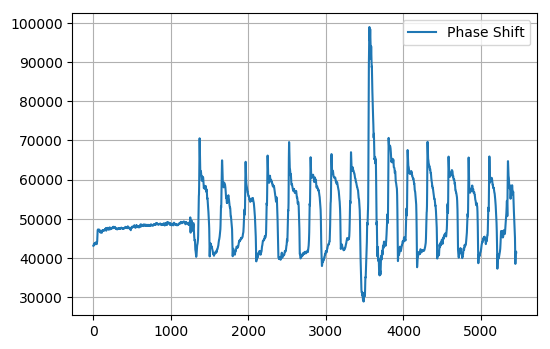

In [3]:
filename = "data/teraterm.csv"
df = pd.read_csv(filename, sep=',', dtype={'Volume_L': np.float})
df.columns = ['Phase Shift']

fig, tx=plt.subplots(dpi=100)
ps_plot, = plt.plot(df.index, df['Phase Shift'], label='Phase Shift')
plt.legend(handles=[ps_plot])
#plt.ylim(54000,59000)
tx.grid()
#plt.savefig('peace.jpg')

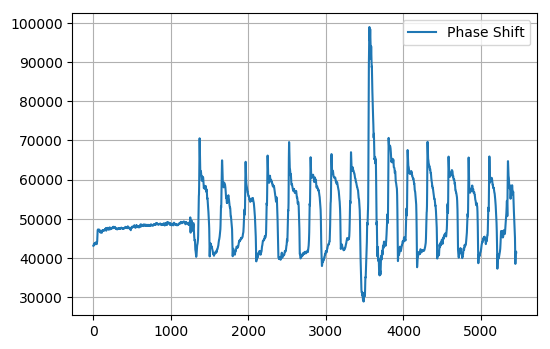

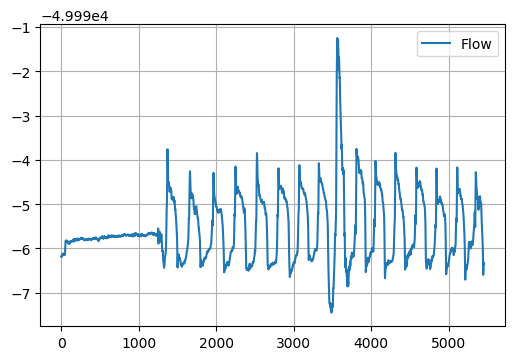

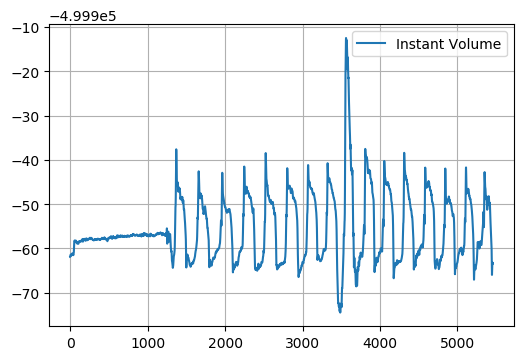

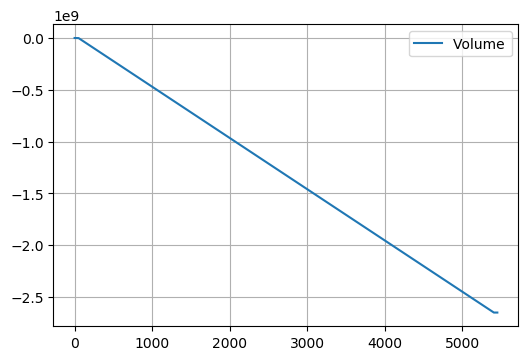

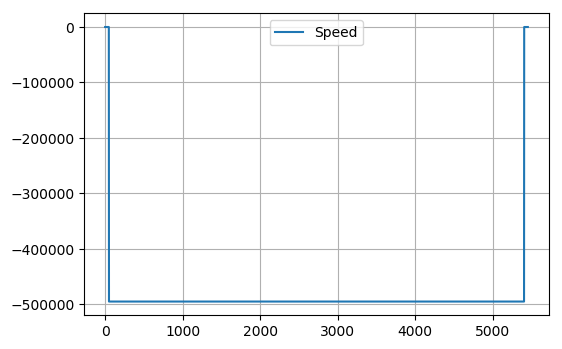

In [4]:
filename = "data/teraterm.csv"
df = pd.read_csv(filename, sep=',', dtype={'Volume_L': np.float})
df.columns = ['Phase Shift']

df['Flow'] = df['Phase Shift'].apply(flow_from_phase_shift).apply(sub_mean)
#df['Flow'] = df['Phase Shift'].apply(flow_from_phase_shift)

df['Instant Volume'] = df['Flow'].apply(flow_to_instant_volume)

ins_volumes = df['Instant Volume'].values

speed_values = []
for i in range(49, len(ins_volumes)-50):
    value = ins_volumes[i-49:i+50].sum()/100.
    speed_values.append(value)

start_speed = speed_values[0]
end_speed = speed_values[len(speed_values)-1]
for i in range(49):
    speed_values.insert(0, 0)
    speed_values.append(0)
    
df['Speed'] = pd.Series(speed_values)

volumes = [np.trapz(speed_values[0:i]) for i in range(len(speed_values))]
df['Volume'] = pd.Series(volumes)

fig, tx=plt.subplots(dpi=100)
ps_plot, = plt.plot(df.index, df['Phase Shift'], label='Phase Shift')
plt.legend(handles=[ps_plot])
plt.savefig('phase_shift.jpg')
tx.grid()

fig, dx=plt.subplots(dpi=100)
flow_plot, = plt.plot(df.index, df['Flow'], label='Flow')
plt.legend(handles=[flow_plot])
plt.savefig('flow.jpg')
dx.grid()

fig, ax=plt.subplots(dpi=100)
instant_volume_plot, = plt.plot(df.index, df['Instant Volume'], label='Instant Volume')
plt.legend(handles=[instant_volume_plot])
plt.savefig('instant_volume.jpg')
ax.grid()

fig, bx=plt.subplots(dpi=100)
volume_plot, = plt.plot(df.index, df['Volume'], label='Volume')
plt.legend(handles=[volume_plot])
plt.savefig('volume.jpg')
bx.grid()

fig, sx=plt.subplots(dpi=100)
speed_plot, = plt.plot(df.index, df['Speed'], label='Speed')
plt.legend(handles=[speed_plot])
plt.savefig('speed.jpg')
sx.grid()

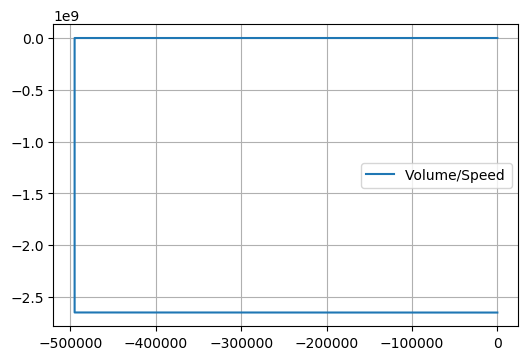

In [5]:
fig, ax=plt.subplots(dpi=100)
volume_speed_plot, = plt.plot(df['Speed'], df['Volume'], label='Volume/Speed')
plt.legend(handles=[volume_speed_plot])
ax.grid()

In [6]:
# Calibrate

calibrate_values = df[df.index < 1]

max_calm_value_by_der = calibrate_values['Speed'].max()
print('Max speed by 1 sec: ', max_calm_value_by_der)
max_calm_value_by_der += max_calm_value_by_der*0.5
print('Modified Max speed by 1 sec: ', max_calm_value_by_der)

Max speed by 1 sec:  0.0
Modified Max speed by 1 sec:  0.0


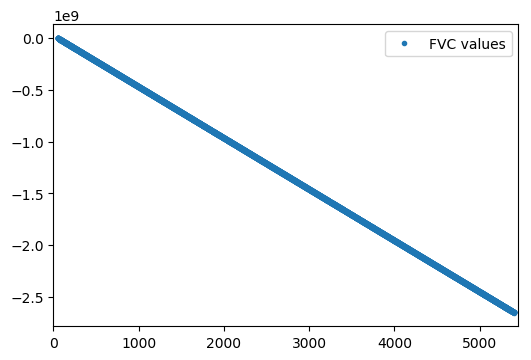

In [7]:
fvc_values = df.loc[np.abs(df['Speed'])>max_calm_value_by_der]

fig, ax=plt.subplots(dpi=100)
fvc_plot, = plt.plot(fvc_values.index, fvc_values['Volume'], '.', label='FVC values')
plt.xlim((df.iloc[0].name, df.iloc[-1].name))
plt.legend(handles=[fvc_plot])

In [8]:
id_min = fvc_values['Volume'].idxmin()
id_max = fvc_values['Volume'].idxmax()

min_point = fvc_values.loc[id_min]
max_point = fvc_values.loc[id_max]

time_max_point = max_point.name
time_min_point = min_point.name
exhale_time = time_max_point - time_min_point

print(min_point, max_point)

Phase Shift       5.769800e+04
Flow             -4.999490e+04
Instant Volume   -4.999490e+05
Speed            -4.949532e+05
Volume           -2.651726e+09
Name: 5407, dtype: float64 Phase Shift        44852.000000
Flow              -49996.033329
Instant Volume   -499960.333289
Speed            -494960.354895
Volume                 0.000000
Name: 49, dtype: float64


In [9]:
# Culculate spyro params

spyro_params = {}

# FVC
fvc = max_point['Volume'] - min_point['Volume']
spyro_params['FVC'] = fvc

# FEV1
fev1_right_point = df.loc[time_max_point+1]
fev1 = max_point['Volume']-fev1_right_point['Volume']
spyro_params['FEV1'] = fev1

# FEV0.5
fevt_right_point = df.loc[time_max_point+0.5]
fevt = max_point['Volume']-fevt_right_point['Volume']
spyro_params['FEV0.5'] = fevt

# FEV0.75
fevt_right_point = df.loc[time_max_point+0.75]
fevt = max_point['Volume']-fevt_right_point['Volume']
spyro_params['FEV0.75'] = fevt

# FEV6

# Need test data for FEV6

# FEV1/VCin
index = fev1/fvc
spyro_params['FEV1/VCin'] = index

# PEF
pef_points = df[(df.index>time_max_point)&(df.index>time_max_point+exhale_time * 0.2)]
max_speed = pef_points['Speed'].max()
spyro_params['PEF'] = max_speed

# FEF
exhale_points = df[(df.index>time_max_point)&(df.index<time_min_point)]

fef_first_point = exhale_points.loc[exhale_points['Volume'].copy().sub(fvc*0.25).abs().idxmin()]
fef_second_point = exhale_points.loc[exhale_points['Volume'].copy().sub(fvc*0.5).abs().idxmin()]
fef_third_point = exhale_points.loc[exhale_points['Volume'].copy().sub(fvc*0.75).abs().idxmin()]

spyro_params['FEF0.25'] = fef_first_point['Volume']
spyro_params['FEF0.5'] = fef_second_point['Volume']
spyro_params['FEF0.75'] = fef_third_point['Volume']

# FEF 0.25-0.75(mean)
exhale_points_25_75 = exhale_points[(exhale_points.index>fef_first_point.name)&(exhale_points.index<fef_third_point.name)]
print(fef_first_point.name, fef_third_point.name)
mean = exhale_points_25_75.mean()
spyro_params['FEF0.25-0.75(mean)'] = mean['Speed']

# FIF
inhale_points = fvc_values[fvc_values.index<max_point.name]

fif_first_point = inhale_points.loc[inhale_points['Volume'].copy().sub(fvc*0.25).abs().idxmin()]
fif_second_point = inhale_points.loc[inhale_points['Volume'].copy().sub(fvc*0.75).abs().idxmin()]

inhale_points_25_75 = inhale_points[(inhale_points.index>fif_first_point.name)&(inhale_points.index<fif_second_point.name)]
mean = inhale_points_25_75.mean()
spyro_params['FIF'] = mean['Speed']

# IC
spyro_params['IC'] = max_point['Volume']

# FET PEF
max_speed_time = pef_points['Speed'].idxmax()
fet_pef = max_speed_time - max_point.name
spyro_params['FET PEF'] = fet_pef

# FET
first_point = fvc_values.iloc[0]
second_point = fvc_values.iloc[-1]

spyro_params['FET'] = second_point.name - first_point.name

spyro_params

TypeError: cannot do label indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [49.5] of <class 'numpy.float64'>